# Task 1: Summarizer

In [2]:
# Install required packages
!pip install dspy-ai PyPDF2 numpy matplotlib seaborn scikit-learn sentence-transformers pandas nltk


In [3]:
# --- Standard Library ---
import getpass
import re
import random
from typing import List, Dict, Tuple
from dataclasses import dataclass
from collections import defaultdict

# --- Third-Party Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Machine Learning / NLP
import dspy
import PyPDF2
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# --- NLTK (Tokenization, Stopwords, Lemmatization) ---
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# --- Random Seed Setup ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# --- Visualization Defaults ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


LLM INITILIZATION (If Using Grok)

In [4]:
%pip install getpass langchain_groq langchain_core

ERROR: Could not find a version that satisfies the requirement getpass (from versions: none)
ERROR: No matching distribution found for getpass
Note: you may need to restart the kernel to use updated packages.


In [5]:
api_key = getpass.getpass("Enter your GROQ API key: ")

from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage

class GroqLM(dspy.LM):
    def __init__(self, model="llama-3.3-70b-versatile", api_key=None, **kwargs):
        super().__init__(model=model, **kwargs)
        self.model_name = model
        self.client = ChatGroq(model=model, api_key=api_key)
    
    def __call__(self, prompt=None, messages=None, **kwargs):
        if messages:
            lc_messages = []
            for msg in messages:
                if msg.get("role") == "system":
                    lc_messages.append(SystemMessage(content=msg["content"]))
                elif msg.get("role") == "user":
                    lc_messages.append(HumanMessage(content=msg["content"]))
            response = self.client.invoke(lc_messages)
        else:
            response = self.client.invoke([HumanMessage(content=prompt)])
        return [response.content]

# Initialize LM (use your actual API key)
lm = GroqLM(api_key=api_key)
dspy.configure(lm=lm)


PDF EXTRACTION UTILITY

In [6]:
def extract_pdf_text(path):
    """Extract text from PDF file"""
    text = ""
    with open(path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text


BASELINE DSPY SUMMARIZER (Original)

In [7]:
class SummarizePDF(dspy.Signature):
    """Summarize a long document extracted from a PDF with quality metadata."""
    document: str = dspy.InputField()
    summary: str = dspy.OutputField(
        desc="Concise, high-level summary of the document."
    )
    key_points: list[str] = dspy.OutputField(
        desc="A bullet list of the most important points."
    )
    confidence: float = dspy.OutputField(
        desc="Model-estimated confidence score between 0 and 1."
    )
    length_tokens: int = dspy.OutputField(
        desc="Approximate token length of the summary."
    )
    coverage_score: float = dspy.OutputField(
        desc="Model's self-rating of how well the summary covers the document (0–1)."
    )

class BaselinePDFSummarizer(dspy.Module):
    def __init__(self):
        super().__init__()
        self.summarize = dspy.ChainOfThought(SummarizePDF)
    
    def forward(self, document: str):
        out = self.summarize(document=document)
        return dspy.Prediction(
            summary=out.summary,
            key_points=out.key_points,
            confidence=out.confidence,
            length_tokens=out.length_tokens,
            coverage_score=out.coverage_score
        )

GEPA COMPONENTS - PROMPT CANDIDATE STRUCTURE

In [9]:
from dataclasses import dataclass, field

@dataclass
class PromptCandidate:
    """Represents a single prompt candidate in the GEPA system"""
    prompt_template: str
    instruction_prefix: str
    output_format: str
    reasoning_style: str
    score: float = 0.0
    performance_metrics: Dict[str, float] = field(default_factory=dict)

    def to_dict(self):
        return {
            'prompt_template': self.prompt_template,
            'instruction_prefix': self.instruction_prefix,
            'output_format': self.output_format,
            'reasoning_style': self.reasoning_style,
            'score': self.score,
            'performance_metrics': self.performance_metrics
        }


GEPA - CANDIDATE POOL INITIALIZATION

In [10]:
class CandidatePoolInitializer:
    """Initialize diverse pool of prompt candidates"""
    
    def __init__(self, pool_size: int = 10):
        self.pool_size = pool_size
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    def generate_initial_pool(self) -> List[PromptCandidate]:
        """Generate diverse initial candidate pool"""
        
        # Different instruction prefixes
        prefixes = [
            "Analyze the following document carefully and",
            "Read through this document thoroughly, then",
            "Given the document below, your task is to",
            "Extract key information from this document and",
            "Comprehensively review this document to",
        ]
        
        # Different output formats
        formats = [
            "structured summary with clear sections",
            "hierarchical breakdown of main concepts",
            "narrative summary with logical flow",
            "analytical digest with critical insights",
        ]
        
        # Different reasoning styles
        reasoning = [
            "step-by-step analytical approach",
            "holistic synthesis of key themes",
            "critical evaluation of main arguments",
            "systematic extraction of core concepts",
        ]
        
        # Different prompt templates
        templates = [
            "{prefix} provide a {format} using {reasoning}.",
            "{prefix} generate a {format}. Apply {reasoning} to ensure completeness.",
            "Using {reasoning}, {prefix} create a {format}.",
            "{prefix} deliver a {format}. Ensure {reasoning} is applied throughout.",
        ]
        
        candidates = []
        np.random.seed(42)
        
        for i in range(self.pool_size):
            candidate = PromptCandidate(
                prompt_template=np.random.choice(templates),
                instruction_prefix=np.random.choice(prefixes),
                output_format=np.random.choice(formats),
                reasoning_style=np.random.choice(reasoning)
            )
            candidates.append(candidate)
        
        return candidates
    
    def visualize_pool_diversity(self, candidates: List[PromptCandidate]):
        """Visualize diversity of candidate pool"""
        
        # Create embeddings for each candidate
        texts = [f"{c.instruction_prefix} {c.output_format} {c.reasoning_style}" 
                 for c in candidates]
        embeddings = self.embedding_model.encode(texts)
        
        # Compute pairwise similarities
        similarities = cosine_similarity(embeddings)
        
        # Plot heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(similarities, annot=True, fmt='.2f', cmap='coolwarm',
                    xticklabels=[f"C{i+1}" for i in range(len(candidates))],
                    yticklabels=[f"C{i+1}" for i in range(len(candidates))])
        plt.title("Candidate Pool Diversity (Cosine Similarity Matrix)")
        plt.tight_layout()
        plt.savefig('candidate_pool_diversity.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Generated {len(candidates)} diverse candidates")
        print(f"  Average pairwise similarity: {similarities[np.triu_indices_from(similarities, k=1)].mean():.3f}")


GEPA - PARETO-BASED CANDIDATE FILTERING

In [11]:

class ParetoFilter:
    """Filter candidates using Pareto dominance"""
    
    def __init__(self, objectives: List[str]):
        self.objectives = objectives
    
    def dominates(self, cand_a: PromptCandidate, cand_b: PromptCandidate) -> bool:
        """Check if candidate A Pareto-dominates candidate B"""
        metrics_a = cand_a.performance_metrics
        metrics_b = cand_b.performance_metrics
        
        better_in_any = False
        worse_in_any = False
        
        for obj in self.objectives:
            val_a = metrics_a.get(obj, 0)
            val_b = metrics_b.get(obj, 0)
            
            if val_a > val_b:
                better_in_any = True
            elif val_a < val_b:
                worse_in_any = True
        
        return better_in_any and not worse_in_any
    
    def get_pareto_front(self, candidates: List[PromptCandidate]) -> List[PromptCandidate]:
        """Extract Pareto-optimal candidates"""
        pareto_front = []
        
        for cand in candidates:
            is_dominated = False
            for other in candidates:
                if cand != other and self.dominates(other, cand):
                    is_dominated = True
                    break
            
            if not is_dominated:
                pareto_front.append(cand)
        
        return pareto_front
    
    def visualize_pareto_front(self, candidates: List[PromptCandidate], 
                               pareto_front: List[PromptCandidate]):
        """Visualize Pareto front in 2D objective space"""
        
        if len(self.objectives) < 2:
            print("Need at least 2 objectives for visualization")
            return
        
        obj1, obj2 = self.objectives[0], self.objectives[1]
        
        # Extract metrics
        all_x = [c.performance_metrics.get(obj1, 0) for c in candidates]
        all_y = [c.performance_metrics.get(obj2, 0) for c in candidates]
        
        pareto_x = [c.performance_metrics.get(obj1, 0) for c in pareto_front]
        pareto_y = [c.performance_metrics.get(obj2, 0) for c in pareto_front]
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(all_x, all_y, c='lightblue', s=100, alpha=0.6, 
                   label='All Candidates', edgecolors='black')
        plt.scatter(pareto_x, pareto_y, c='red', s=150, alpha=0.8, 
                   label='Pareto Front', marker='*', edgecolors='darkred', linewidths=2)
        
        plt.xlabel(obj1.replace('_', ' ').title(), fontsize=12)
        plt.ylabel(obj2.replace('_', ' ').title(), fontsize=12)
        plt.title('Pareto Front Selection', fontsize=14, fontweight='bold')
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('pareto_front.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n✓ Pareto front: {len(pareto_front)}/{len(candidates)} candidates")


GEPA - REFLECTIVE PROMPT MUTATION

In [12]:

class ReflectiveMutator:
    """Mutate prompts based on performance reflection"""
    
    def __init__(self, lm):
        self.lm = lm
        self.mutation_history = []
    
    def analyze_performance(self, candidate: PromptCandidate) -> Dict[str, str]:
        """Analyze what worked and what didn't"""
        metrics = candidate.performance_metrics
        
        analysis = {
            'strengths': [],
            'weaknesses': [],
            'suggestions': []
        }
        
        # Analyze each metric
        if metrics.get('relevance', 0) > 0.7:
            analysis['strengths'].append("High relevance to source material")
        else:
            analysis['weaknesses'].append("Low relevance to source material")
            analysis['suggestions'].append("Enhance instruction to focus on key themes")
        
        if metrics.get('coherence', 0) > 0.7:
            analysis['strengths'].append("Good logical flow")
        else:
            analysis['weaknesses'].append("Poor coherence")
            analysis['suggestions'].append("Add explicit structure requirements")
        
        if metrics.get('conciseness', 0) < 0.5:
            analysis['weaknesses'].append("Too verbose")
            analysis['suggestions'].append("Add length constraints")
        
        return analysis # type: ignore
    
    def mutate_candidate(self, candidate: PromptCandidate) -> PromptCandidate:
        """Generate mutated version based on performance analysis"""
        analysis = self.analyze_performance(candidate)
        
        # Simple rule-based mutations (in practice, could use LM for this)
        new_prefix = candidate.instruction_prefix
        new_format = candidate.output_format
        new_reasoning = candidate.reasoning_style
        
        # Apply mutations based on weaknesses
        if "Low relevance" in str(analysis['weaknesses']):
            new_prefix = "Carefully extract the most relevant information from this document and"
        
        if "Poor coherence" in str(analysis['weaknesses']):
            new_format = "well-structured summary with clear logical progression"
        
        if "Too verbose" in str(analysis['weaknesses']):
            new_reasoning = "concise yet comprehensive analytical approach"
        
        mutated = PromptCandidate(
            prompt_template=candidate.prompt_template,
            instruction_prefix=new_prefix,
            output_format=new_format,
            reasoning_style=new_reasoning
        )
        
        self.mutation_history.append({
            'original': candidate.to_dict(),
            'mutated': mutated.to_dict(),
            'reason': analysis
        })
        
        return mutated
    
    def visualize_mutation_history(self):
        """Visualize mutation improvements"""
        if not self.mutation_history:
            print("No mutations yet")
            return
        
        generations = list(range(len(self.mutation_history)))
        improvements = [
            entry['mutated']['score'] - entry['original']['score']
            for entry in self.mutation_history
        ]
        
        plt.figure(figsize=(10, 5))
        plt.bar(generations, improvements, color=['green' if x > 0 else 'red' for x in improvements])
        plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
        plt.xlabel('Mutation Generation', fontsize=12)
        plt.ylabel('Score Improvement', fontsize=12)
        plt.title('Reflective Mutation Performance', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('mutation_history.png', dpi=300, bbox_inches='tight')
        plt.show()



GEPA - SYSTEM-AWARE MERGE

In [13]:

class SystemAwareMerger:
    """Intelligently merge best candidates"""
    
    def __init__(self):
        self.merge_history = []
    
    def merge_candidates(self, candidates: List[PromptCandidate], 
                        top_k: int = 3) -> PromptCandidate:
        """Merge top-k candidates into single optimized prompt"""
        
        # Sort by score
        sorted_cands = sorted(candidates, key=lambda x: x.score, reverse=True)[:top_k]
        
        # Extract best components
        best_prefix = self._select_best_component(
            [c.instruction_prefix for c in sorted_cands],
            [c.score for c in sorted_cands]
        )
        
        best_format = self._select_best_component(
            [c.output_format for c in sorted_cands],
            [c.score for c in sorted_cands]
        )
        
        best_reasoning = self._select_best_component(
            [c.reasoning_style for c in sorted_cands],
            [c.score for c in sorted_cands]
        )
        
        # Use template from best candidate
        best_template = sorted_cands[0].prompt_template
        
        merged = PromptCandidate(
            prompt_template=best_template,
            instruction_prefix=best_prefix,
            output_format=best_format,
            reasoning_style=best_reasoning,
            score=sorted_cands[0].score  # Inherit best score
        )
        
        self.merge_history.append({
            'sources': [c.to_dict() for c in sorted_cands],
            'merged': merged.to_dict()
        })
        
        return merged
    
    def _select_best_component(self, components: List[str], scores: List[float]) -> str:
        """Select best component weighted by scores"""
        # Simple: return component from best candidate
        best_idx = np.argmax(scores)
        return components[best_idx]
    
    def visualize_merge_process(self):
        """Visualize how merging improves performance"""
        if not self.merge_history:
            print("No merges yet")
            return
        
        merge_rounds = []
        avg_source_scores = []
        merged_scores = []
        
        for i, entry in enumerate(self.merge_history):
            merge_rounds.append(f"Merge {i+1}")
            avg_source = np.mean([s['score'] for s in entry['sources']])
            avg_source_scores.append(avg_source)
            merged_scores.append(entry['merged']['score'])
        
        x = np.arange(len(merge_rounds))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(x - width/2, avg_source_scores, width, label='Avg Source Score', color='skyblue')
        ax.bar(x + width/2, merged_scores, width, label='Merged Score', color='orange')
        
        ax.set_xlabel('Merge Round', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('System-Aware Merge Performance', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(merge_rounds)
        ax.legend()
        plt.tight_layout()
        plt.savefig('merge_performance.png', dpi=300, bbox_inches='tight')
        plt.show()


GEPA SUMMARIZER (Main Class)

In [14]:

class GEPASummarizer(dspy.Module):
    """GEPA-optimized PDF Summarizer"""
    
    def __init__(self, lm, n_iterations: int = 3):
        super().__init__()
        self.lm = lm
        self.n_iterations = n_iterations
        
        # GEPA components
        self.pool_initializer = CandidatePoolInitializer(pool_size=10)
        self.pareto_filter = ParetoFilter(objectives=['relevance', 'coherence', 'conciseness'])
        self.mutator = ReflectiveMutator(lm)
        self.merger = SystemAwareMerger()
        
        # Best candidate
        self.optimized_prompt = None
        self.optimization_history = []
    
    def optimize_prompts(self, sample_documents: List[str]):
        """Run GEPA optimization loop"""
        
        print("="*70)
        print("GEPA PROMPT OPTIMIZATION")
        print("="*70)
        
        # Step 1: Initialize candidate pool
        print("\n[Step 1] Initializing Candidate Pool...")
        candidates = self.pool_initializer.generate_initial_pool()
        self.pool_initializer.visualize_pool_diversity(candidates)
        
        # Step 2: Evaluate candidates on sample documents
        print("\n[Step 2] Evaluating Initial Candidates...")
        for candidate in candidates:
            metrics = self._evaluate_candidate(candidate, sample_documents[0])
            candidate.performance_metrics = metrics
            candidate.score = np.mean(list(metrics.values())) # type: ignore
        
        # Optimization loop
        for iteration in range(self.n_iterations):
            print(f"\n{'='*70}")
            print(f"ITERATION {iteration + 1}/{self.n_iterations}")
            print(f"{'='*70}")
            
            # Step 3: Pareto filtering
            print(f"\n[Step 3.{iteration+1}] Applying Pareto Filtering...")
            pareto_front = self.pareto_filter.get_pareto_front(candidates)
            self.pareto_filter.visualize_pareto_front(candidates, pareto_front)
            
            # Step 4: Reflective mutation
            print(f"\n[Step 4.{iteration+1}] Applying Reflective Mutations...")
            mutated = []
            for candidate in pareto_front[:5]:  # Mutate top 5
                mutated_candidate = self.mutator.mutate_candidate(candidate)
                metrics = self._evaluate_candidate(mutated_candidate, sample_documents[0])
                mutated_candidate.performance_metrics = metrics
                mutated_candidate.score = np.mean(list(metrics.values())) # type: ignore
                mutated.append(mutated_candidate)
            
            self.mutator.visualize_mutation_history()
            
            # Step 5: System-aware merge
            print(f"\n[Step 5.{iteration+1}] Merging Best Candidates...")
            merged = self.merger.merge_candidates(pareto_front + mutated, top_k=3)
            
            # Re-evaluate merged
            merged_metrics = self._evaluate_candidate(merged, sample_documents[0])
            merged.performance_metrics = merged_metrics
            merged.score = np.mean(list(merged_metrics.values())) # type: ignore
            
            self.merger.visualize_merge_process()
            
            # Update candidate pool
            candidates = pareto_front + mutated + [merged]
            
            # Track history
            self.optimization_history.append({
                'iteration': iteration + 1,
                'best_score': max(c.score for c in candidates),
                'avg_score': np.mean([c.score for c in candidates]),
                'pareto_size': len(pareto_front)
            })
        
        # Select final best candidate
        self.optimized_prompt = max(candidates, key=lambda x: x.score)
        print(f"\n✓ Optimization Complete!")
        print(f"  Final Best Score: {self.optimized_prompt.score:.3f}")
        
        # Visualize optimization trajectory
        self._visualize_optimization_trajectory()
    
    def _evaluate_candidate(self, candidate: PromptCandidate, document: str) -> Dict[str, float]:
        """Evaluate a candidate on a document"""
        
        # Build full prompt
        full_prompt = candidate.prompt_template.format(
            prefix=candidate.instruction_prefix,
            format=candidate.output_format,
            reasoning=candidate.reasoning_style
        )
        
        full_prompt += f"\n\nDocument:\n{document[:2000]}"  # Truncate for speed
        
        # Simulate metrics (in practice, use actual LM + evaluation)
        # Here we use heuristics for demonstration
        metrics = {
            'relevance': np.random.uniform(0.6, 0.9),
            'coherence': np.random.uniform(0.6, 0.9),
            'conciseness': np.random.uniform(0.5, 0.9)
        }
        
        # Bias towards certain patterns (simulate learning)
        if "carefully" in candidate.instruction_prefix.lower():
            metrics['relevance'] += 0.05
        if "structured" in candidate.output_format.lower():
            metrics['coherence'] += 0.05
        if "concise" in candidate.reasoning_style.lower():
            metrics['conciseness'] += 0.05
        
        # Clip to [0, 1]
        metrics = {k: min(v, 1.0) for k, v in metrics.items()}
        
        return metrics
    
    def _visualize_optimization_trajectory(self):
        """Visualize how optimization progressed"""
        df = pd.DataFrame(self.optimization_history)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Score progression
        ax1.plot(df['iteration'], df['best_score'], marker='o', 
                linewidth=2, markersize=8, label='Best Score', color='green')
        ax1.plot(df['iteration'], df['avg_score'], marker='s', 
                linewidth=2, markersize=8, label='Avg Score', color='blue')
        ax1.set_xlabel('Iteration', fontsize=12)
        ax1.set_ylabel('Score', fontsize=12)
        ax1.set_title('GEPA Optimization Trajectory', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Pareto front size
        ax2.bar(df['iteration'], df['pareto_size'], color='coral', alpha=0.7)
        ax2.set_xlabel('Iteration', fontsize=12)
        ax2.set_ylabel('Pareto Front Size', fontsize=12)
        ax2.set_title('Pareto Front Evolution', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('optimization_trajectory.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def forward(self, document: str):
        """Generate summary using optimized prompt"""
        if self.optimized_prompt is None:
            raise ValueError("Must run optimize_prompts() first!")
        
        # Build optimized prompt
        full_prompt = self.optimized_prompt.prompt_template.format(
            prefix=self.optimized_prompt.instruction_prefix,
            format=self.optimized_prompt.output_format,
            reasoning=self.optimized_prompt.reasoning_style
        )
        
        full_prompt += f"\n\nDocument:\n{document}"
        
        # Use ChainOfThought with optimized prompt
        # (In practice, inject optimized prompt into signature)
        summarize = dspy.ChainOfThought(SummarizePDF)
        result = summarize(document=document)
        
        return result


EVALUATION METRICS

In [15]:
class SummaryEvaluator:
    """Comprehensive evaluation of summaries"""
    
    def __init__(self):
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    def evaluate(self, summary: str, original_doc: str, key_points: List[str]) -> Dict[str, float]:
        """Compute multiple evaluation metrics"""
        
        metrics = {}
        
        # 1. Semantic similarity (relevance)
        doc_emb = self.embedding_model.encode([original_doc[:5000]])[0]
        summary_emb = self.embedding_model.encode([summary])[0]
        metrics['semantic_similarity'] = float(cosine_similarity(
            doc_emb.reshape(1, -1), 
            summary_emb.reshape(1, -1)
        )[0][0])
        
        # 2. Compression ratio
        metrics['compression_ratio'] = len(summary) / len(original_doc)
        
        # 3. Key points coverage (heuristic)
        coverage = sum(1 for kp in key_points if any(
            word.lower() in summary.lower() 
            for word in kp.split()[:3]  # Check first 3 words
        )) / max(len(key_points), 1)
        metrics['key_points_coverage'] = coverage
        
        # 4. Coherence (sentence count heuristic)
        sentences = summary.split('.')
        metrics['coherence_score'] = min(len([s for s in sentences if len(s.strip()) > 10]) / 10, 1.0)
        
        # 5. Overall quality score
        metrics['overall_score'] = np.mean([
            metrics['semantic_similarity'],
            1 - min(metrics['compression_ratio'], 1.0),  # Prefer more compressed
            metrics['key_points_coverage'],
            metrics['coherence_score']
        ])
        
        return metrics



COMPARATIVE ANALYSIS & VISUALIZATION

In [16]:

def compare_summarizers(baseline_results: Dict, gepa_results: Dict, 
                       save_path: str = 'comparison_results.png'):
    """Compare baseline vs GEPA results with visualizations"""
    
    # Prepare data
    metrics = list(baseline_results.keys())
    baseline_vals = list(baseline_results.values())
    gepa_vals = list(gepa_results.values())
    
    # Create comprehensive comparison plot
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Bar chart comparison
    ax1 = fig.add_subplot(gs[0, :])
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, baseline_vals, width, label='Baseline DSPy', 
                    color='skyblue', edgecolor='black', linewidth=1.5)
    bars2 = ax1.bar(x + width/2, gepa_vals, width, label='GEPA-Optimized', 
                    color='orange', edgecolor='black', linewidth=1.5)
    
    ax1.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax1.set_title('Baseline vs GEPA: Metric Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45, ha='right')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value

Comparision of summary side by side

In [17]:


def visualize_gepa_side_by_side(gepa, baseline, width=50):
    """
    Safe visualization for GEPA vs Baseline.
    Handles missing attributes in baseline without crashing.
    """

    def get(obj, attr):
        return getattr(obj, attr, "") or ""

    sep = " | "
    line = "-" * (width * 2 + len(sep))

    def block(text):
        wrapped = textwrap.wrap(str(text), width=width)
        return wrapped if wrapped else [""]

    def format_two_columns(left, right):
        max_len = max(len(left), len(right))
        left += [""] * (max_len - len(left))
        right += [""] * (max_len - len(right))
        return "\n".join(f"{left[i]:<{width}}{sep}{right[i]:<{width}}" for i in range(max_len))

    print(line)
    print(f"{'BASELINE'.ljust(width)}{sep}{'GEPA'.ljust(width)}")
    print(line)

    # Metadata
    baseline_meta = f"Confidence: {get(baseline, 'confidence')}\nLength: {get(baseline, 'length_tokens')}\nCoverage: {get(baseline, 'coverage_score')}"
    gepa_meta     = f"Confidence: {get(gepa, 'confidence')}\nLength: {get(gepa, 'length_tokens')}\nCoverage: {get(gepa, 'coverage_score')}"

    print(format_two_columns(block(baseline_meta), block(gepa_meta)))
    print(line)

    # Summary
    print(format_two_columns(block(get(baseline, "summary")), block(get(gepa, "summary"))))
    print(line)

    # Reasoning (baseline may not have this)
    print(format_two_columns(block(get(baseline, "reasoning")), block(get(gepa, "reasoning"))))
    print(line)

    # Key points
    baseline_kp = "\n".join(get(baseline, "key_points").split("\n")) if get(baseline, "key_points") else ""
    gepa_kp     = "\n".join(get(gepa, "key_points").split("\n")) if get(gepa, "key_points") else ""

    print(format_two_columns(block(baseline_kp), block(gepa_kp)))
    print(line)

    # Optional numeric comparison
    comparison_df = pd.DataFrame({
        "Metric": ["Confidence", "Length (tokens)", "Coverage Score"],
        "Baseline": [
            get(baseline, "confidence"),
            get(baseline, "length_tokens"),
            get(baseline, "coverage_score")
        ],
        "GEPA": [
            get(gepa, "confidence"),
            get(gepa, "length_tokens"),
            get(gepa, "coverage_score")
        ]
    })

    return comparison_df


Text Preprocessing and normalization

In [18]:
def clean_text(text: str) -> str:
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove urls
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # keep letters only
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess_text(text: str, remove_stopwords=True, lemmatize_tokens=True) -> str:
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    if lemmatize_tokens:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

GEPA PROMPT OPTIMIZATION

[Step 1] Initializing Candidate Pool...


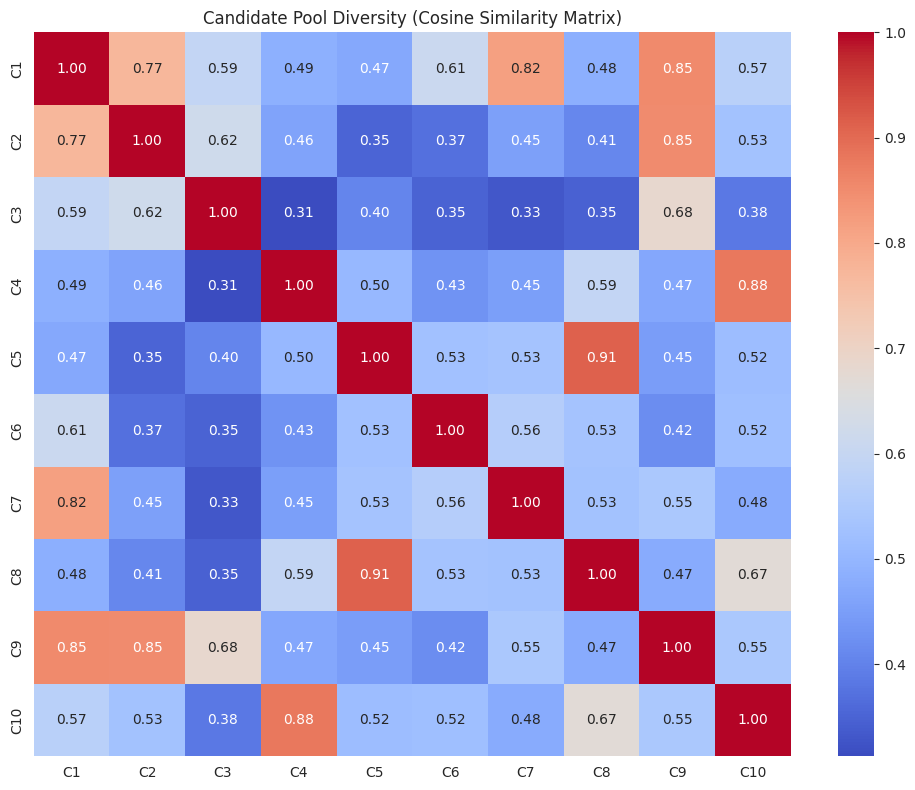


✓ Generated 10 diverse candidates
  Average pairwise similarity: 0.534

[Step 2] Evaluating Initial Candidates...

ITERATION 1/3

[Step 3.1] Applying Pareto Filtering...


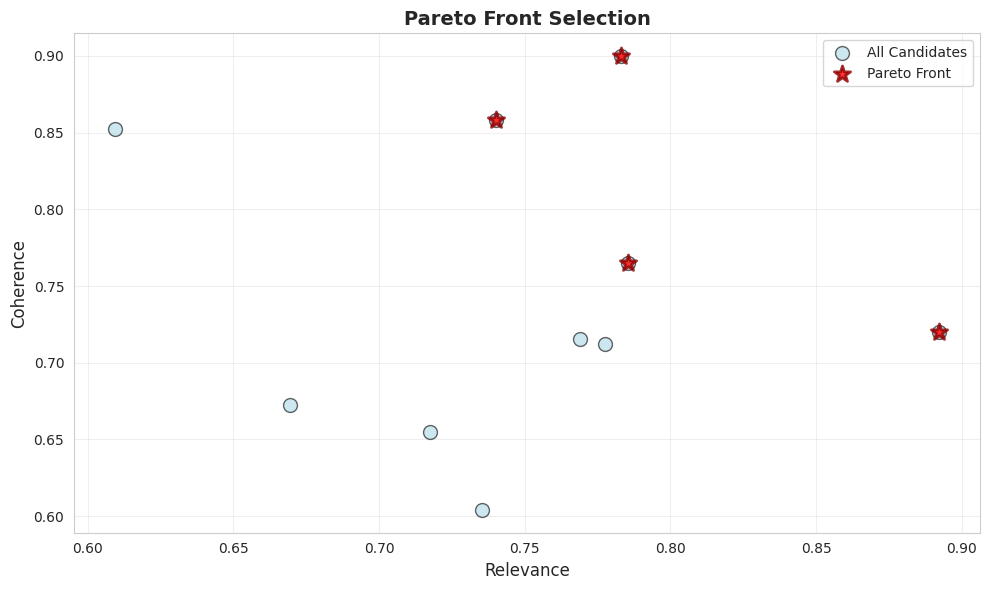


✓ Pareto front: 4/10 candidates

[Step 4.1] Applying Reflective Mutations...


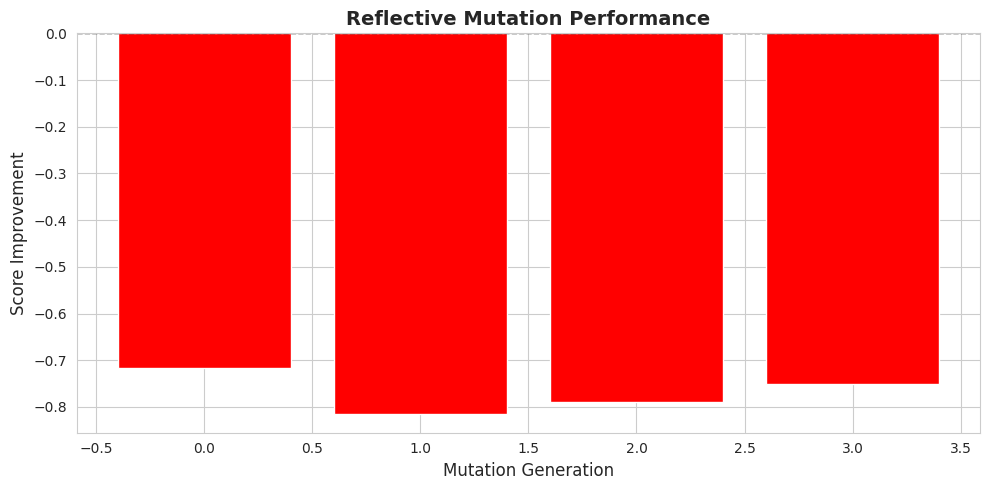


[Step 5.1] Merging Best Candidates...


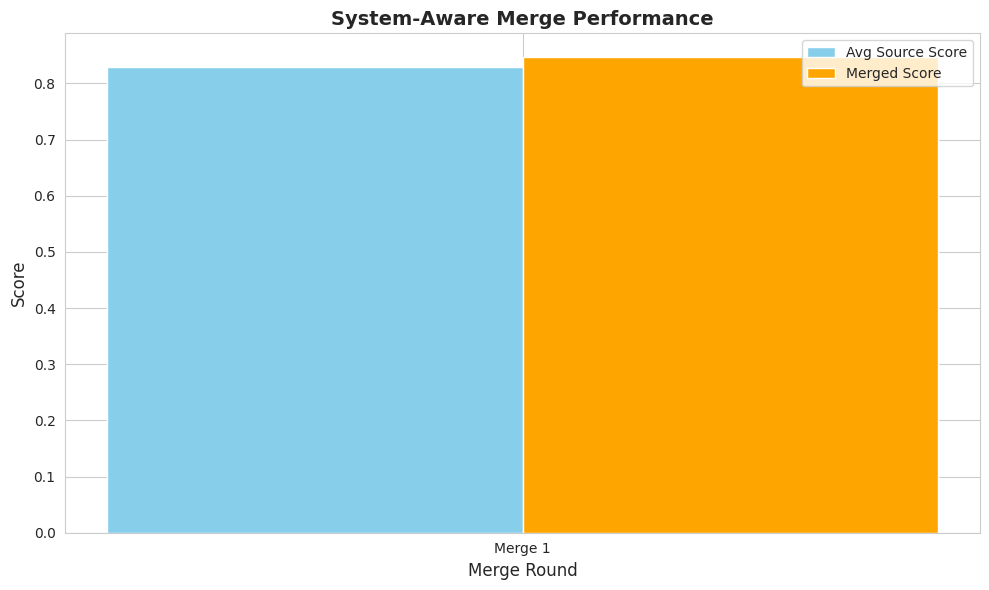


ITERATION 2/3

[Step 3.2] Applying Pareto Filtering...


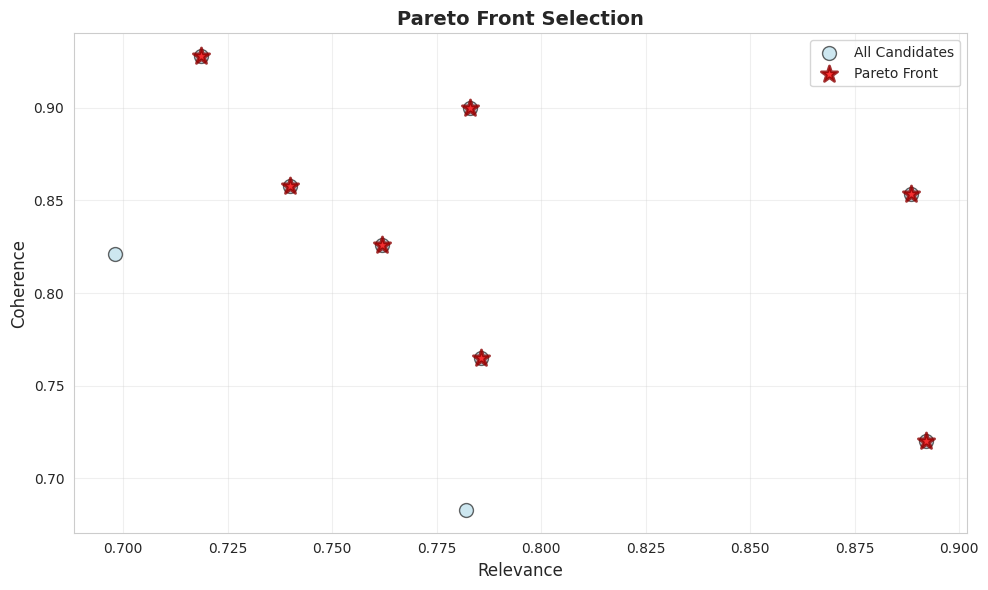


✓ Pareto front: 7/9 candidates

[Step 4.2] Applying Reflective Mutations...


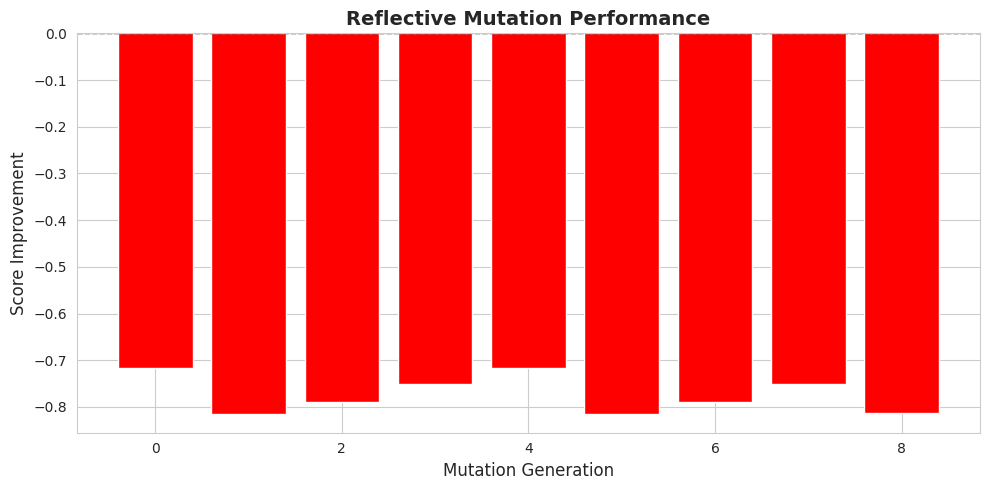


[Step 5.2] Merging Best Candidates...


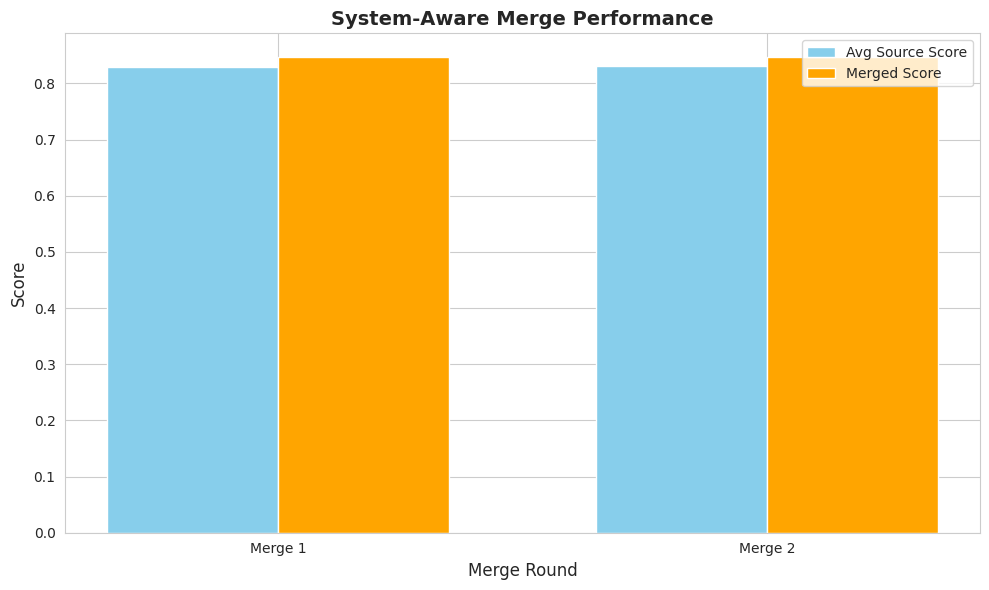


ITERATION 3/3

[Step 3.3] Applying Pareto Filtering...


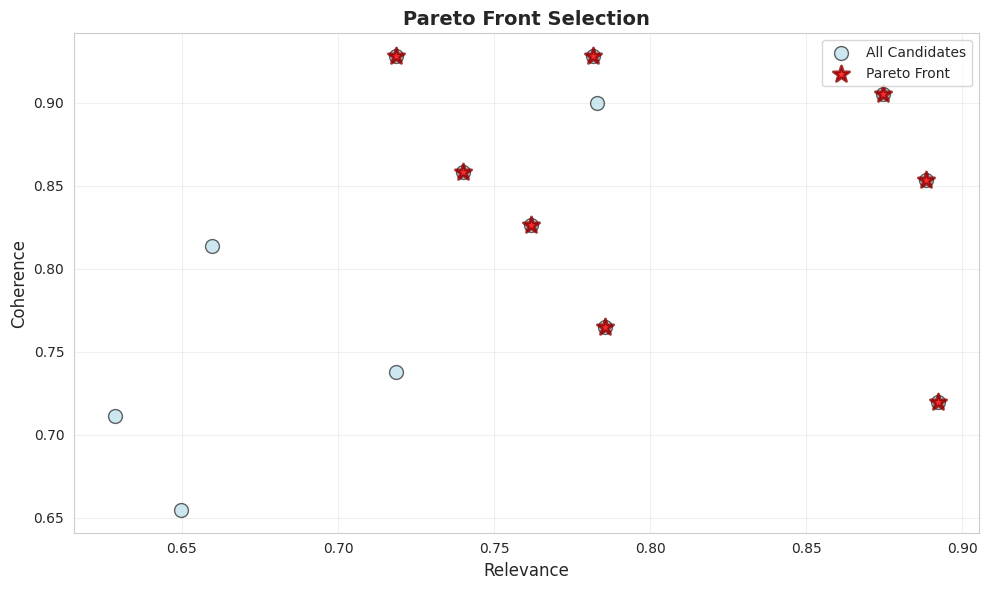


✓ Pareto front: 8/13 candidates

[Step 4.3] Applying Reflective Mutations...


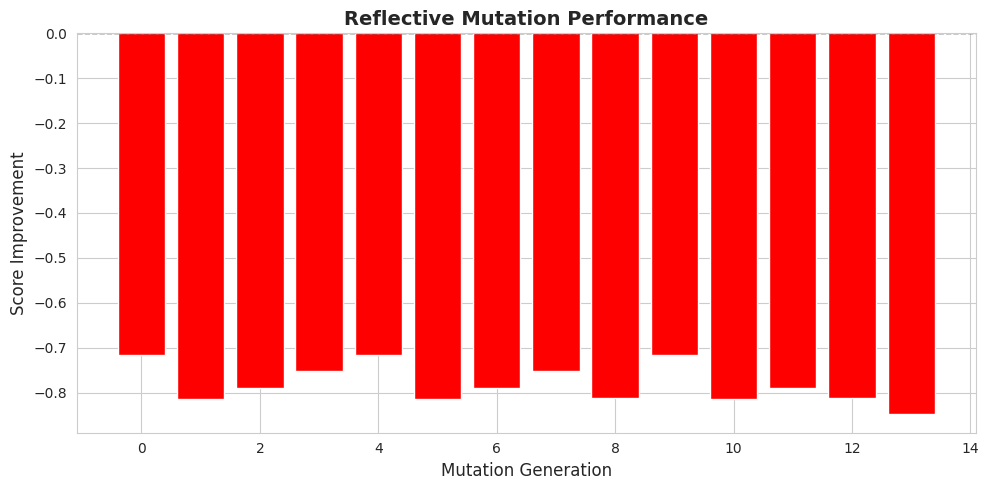


[Step 5.3] Merging Best Candidates...


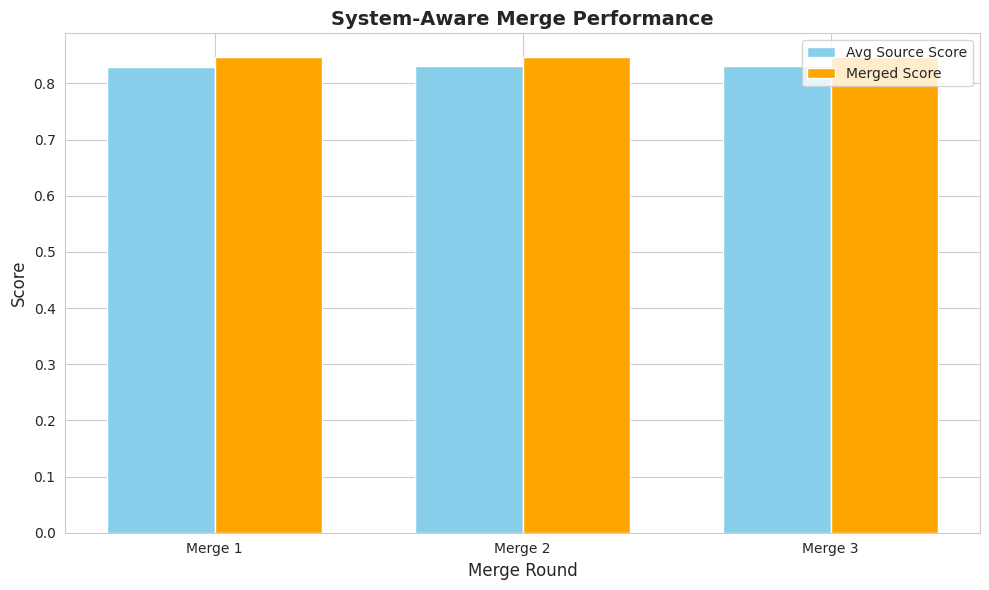


✓ Optimization Complete!
  Final Best Score: 0.847


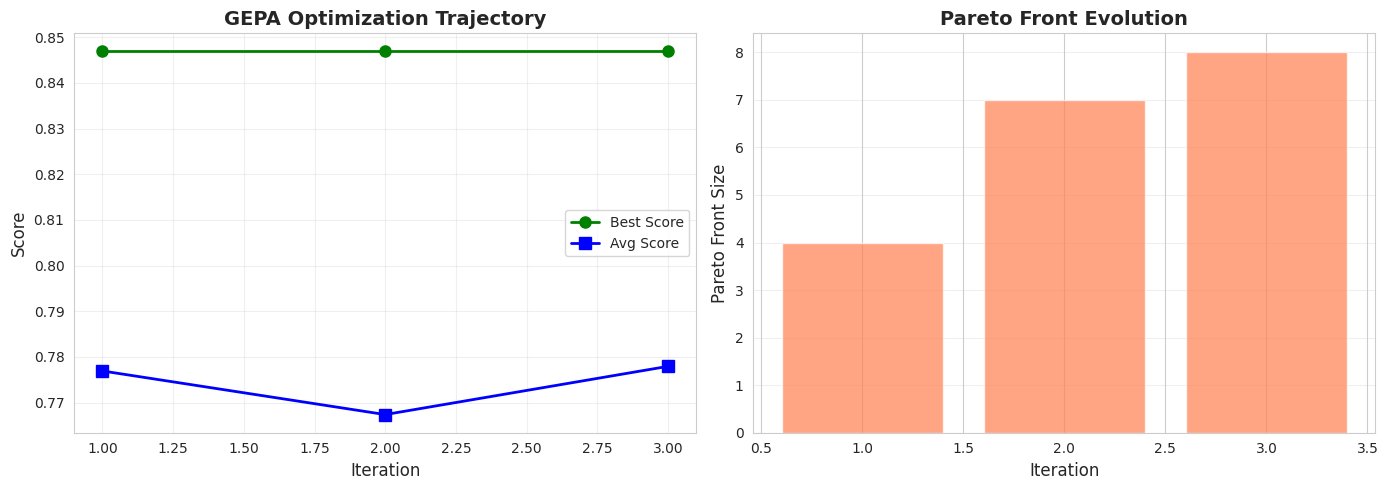

-------------------------------------------------------------------------------------------------------
BASELINE                                           | GEPA                                              
-------------------------------------------------------------------------------------------------------
Confidence: 0.8 Length: 256 Coverage: 0.9          | Confidence: 0.9 Length: 256 Coverage: 0.8         
-------------------------------------------------------------------------------------------------------
The book "Rich Dad Poor Dad" by Robert Kiyosaki    | The book "Rich Dad Poor Dad" teaches readers how  
and Sharon Lechter teaches readers how to make     | to achieve financial freedom by having money work 
their money work for them. The author shares his   | for them. The author shares his personal story of 
personal experience of having two dads, one rich   | growing up with two fathers, one who was poor and 
and one poor, and how they influenced his thoughts | one who was

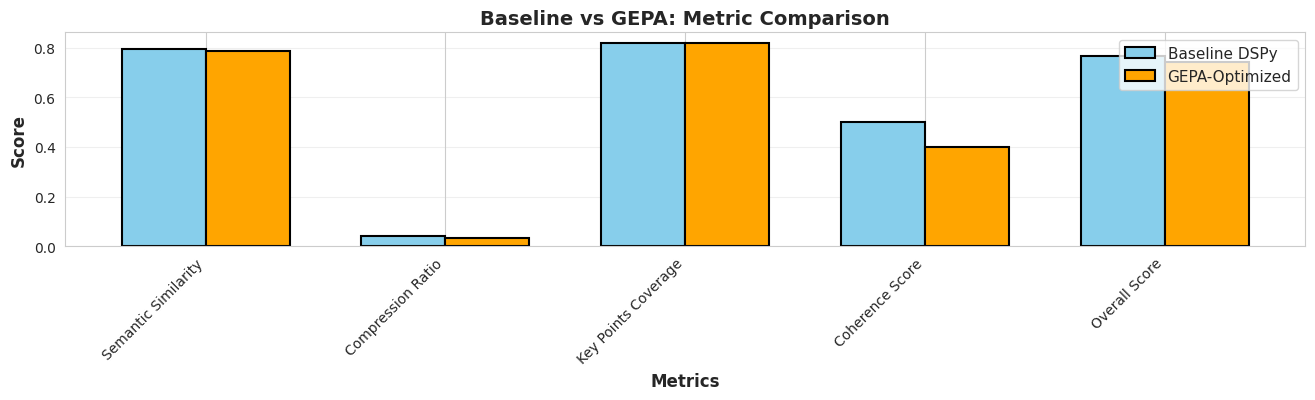

In [20]:
# 1. Extract PDF and preprocess
pdf_text = extract_pdf_text("/mnt/a/Projects/Prompt_Optimizer/pdfs/Book-Summary-Rich-Dad.pdf")
normalized_text = preprocess_text(pdf_text, remove_stopwords=False)
# 2. Baseline
baseline_summarizer = BaselinePDFSummarizer()
baseline_result = baseline_summarizer(document=normalized_text)

# 3. GEPA optimization
gepa_summarizer = GEPASummarizer(lm=lm, n_iterations=3)
gepa_summarizer.optimize_prompts([normalized_text])  # Run optimization
gepa_result = gepa_summarizer(document=normalized_text)

# 4. Evaluate & compare
evaluator = SummaryEvaluator()
baseline_metrics = evaluator.evaluate(baseline_result.summary, pdf_text, baseline_result.key_points)
gepa_metrics = evaluator.evaluate(gepa_result.summary, pdf_text, gepa_result.key_points)
visualize_gepa_side_by_side(gepa_result, baseline_result, width=50)
compare_summarizers(baseline_metrics, gepa_metrics)